# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list
from pyspark.sql.types import IntegerType, BooleanType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
import seaborn as sns


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()


Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [7]:
df.select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [8]:
df.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [9]:
df.select('location').distinct().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [10]:
df.select('page').distinct().show(50)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Select only relevant columns and remove the others

In [11]:
df_clean = df.select('artist','auth','firstName','gender','lastName','length','level','location','page','song','ts','userId')

In [12]:
df_clean.where((col("page") == "Cancellation Confirmation")).select("userId").distinct().count()

52

In [13]:
df_clean.filter(df_clean.auth=="Cancelled").show()

+------+---------+---------+------+---------+------+-----+--------------------+--------------------+----+-------------+------+
|artist|     auth|firstName|gender| lastName|length|level|            location|                page|song|           ts|userId|
+------+---------+---------+------+---------+------+-----+--------------------+--------------------+----+-------------+------+
|  null|Cancelled|   Adriel|     M|  Mendoza|  null| paid|  Kansas City, MO-KS|Cancellation Conf...|null|1538943990000|    18|
|  null|Cancelled|    Diego|     M|    Mckee|  null| paid|Phoenix-Mesa-Scot...|Cancellation Conf...|null|1539033046000|    32|
|  null|Cancelled|    Mason|     M|     Hart|  null| free|  Corpus Christi, TX|Cancellation Conf...|null|1539318918000|   125|
|  null|Cancelled|Alexander|     M|   Garcia|  null| paid|Indianapolis-Carm...|Cancellation Conf...|null|1539375441000|   105|
|  null|Cancelled|    Kayla|     F|  Johnson|  null| paid|Philadelphia-Camd...|Cancellation Conf...|null|153946

In [14]:
churnedUsers = df_clean.filter(df_clean.auth=="Cancelled")

In [15]:
churnedUsers.select("userId").distinct().count()

52

In [16]:
df_clean.select("userId").distinct().count()

226

We have 23% of Churned users in the mini dataset.

In [17]:
# Add column Churn
df_churn = df_clean.groupby('userId').agg(collect_list('auth').alias("auths"))
churned = udf(lambda x: 'Cancelled' in x)
df_churn = df_churn.withColumn("Churned", churned(df_churn.auths))
df_churn = df_churn.drop('auths')
df_label = df_churn.join(df_clean,'userId')

In [18]:
df_label.show()

+------+-------+--------------------+---------+---------+------+---------+---------+-----+--------------------+-----------+--------------------+-------------+
|userId|Churned|              artist|     auth|firstName|gender| lastName|   length|level|            location|       page|                song|           ts|
+------+-------+--------------------+---------+---------+------+---------+---------+-----+--------------------+-----------+--------------------+-------------+
|100010|  false|Sleeping With Sirens|Logged In| Darianna|     F|Carpenter|202.97098| free|Bridgeport-Stamfo...|   NextSong|Captain Tyin Knot...|1539003534000|
|100010|  false|Francesca Battist...|Logged In| Darianna|     F|Carpenter|196.54485| free|Bridgeport-Stamfo...|   NextSong|Beautiful_ Beauti...|1539003736000|
|100010|  false|              Brutha|Logged In| Darianna|     F|Carpenter|263.13098| free|Bridgeport-Stamfo...|   NextSong|          She's Gone|1539003932000|
|100010|  false|                null|Logged In

In [19]:
df_label.groupby("Churned").avg("length").collect()

[Row(Churned='false', avg(length)=249.20913538880816),
 Row(Churned='true', avg(length)=248.63279564406218)]

In [20]:
df_label.select(["userId","Churned"]).distinct().groupBy("Churned").count().collect()

[Row(Churned='false', count=174), Row(Churned='true', count=52)]

In [21]:
df_label.filter((col('userId')==100003) & (col('song')!='null')).show()

+------+-------+--------------------+---------+---------+------+--------+---------+-----+--------------------+--------+--------------------+-------------+
|userId|Churned|              artist|     auth|firstName|gender|lastName|   length|level|            location|    page|                song|           ts|
+------+-------+--------------------+---------+---------+------+--------+---------+-----+--------------------+--------+--------------------+-------------+
|100003|   true|     Black Eyed Peas|Logged In|   Nevaeh|     F|   Jones|193.88036| free|Miami-Fort Lauder...|NextSong|          Gone Going|1539100420000|
|100003|   true|            Paramore|Logged In|   Nevaeh|     F|   Jones|193.56689| free|Miami-Fort Lauder...|NextSong|All We Know (Albu...|1539100613000|
|100003|   true| A Love Ends Suicide|Logged In|   Nevaeh|     F|   Jones|197.32853| free|Miami-Fort Lauder...|NextSong|     Heroes Of Faith|1539263080000|
|100003|   true|               Stars|Logged In|   Nevaeh|     F|   Jon

In [22]:
#Number of Thumbs Up
thumbsUp = df_label.where(df_label.page=='Thumbs Up').groupby("userId").agg(count(col('page')).alias('ThumbsUp')).orderBy('userId')
thumbsUp.show()

+------+--------+
|userId|ThumbsUp|
+------+--------+
|    10|      37|
|   100|     148|
|100001|       8|
|100002|       5|
|100003|       3|
|100004|      35|
|100005|       7|
|100006|       2|
|100007|      19|
|100008|      37|
|100009|      23|
|100010|      17|
|100012|      18|
|100013|      39|
|100014|      17|
|100015|      35|
|100016|      25|
|100017|       2|
|100018|      46|
|100019|       1|
+------+--------+
only showing top 20 rows



In [23]:
#Number of Thumbs down
thumbsDown = df_label.where(df_label.page=='Thumbs Down').groupby("userId").agg(count(col('page')).alias('ThumbsDown')).orderBy('userId')
thumbsDown.show()

+------+----------+
|userId|ThumbsDown|
+------+----------+
|    10|         4|
|   100|        27|
|100001|         2|
|100004|        11|
|100005|         3|
|100006|         2|
|100007|         6|
|100008|         6|
|100009|         8|
|100010|         5|
|100011|         1|
|100012|         9|
|100013|        15|
|100014|         3|
|100015|         8|
|100016|         5|
|100017|         1|
|100018|         9|
|100019|         1|
|100021|         5|
+------+----------+
only showing top 20 rows



In [24]:
allThumbs = thumbsUp.join(thumbsDown,'userId')

In [25]:
#Number of songs played
songsPlayed = df_label.where(col('song')!='null').groupby("userId").agg(count(col('song')).alias('SongsPlayed')).orderBy('userId')
songsPlayed.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [26]:
df_features = df_churn.join(songsPlayed,'userId')

In [27]:
df_features = df_features.join(allThumbs,'userId')

In [28]:
#No of days in Sparkify from column "ts"(length of session)
days = df_label.groupby('userId').agg(((max(col('ts')) - min(col('ts')))/86400000).alias("Days"))
days.show()

+------+-------------------+
|userId|               Days|
+------+-------------------+
|100010|  44.21780092592593|
|200002| 45.496805555555554|
|   125|0.02053240740740741|
|   124| 59.996944444444445|
|    51| 15.779398148148148|
|     7| 50.784050925925925|
|    15|  54.77318287037037|
|    54|  42.79719907407407|
|   155|  25.82783564814815|
|100014| 41.244363425925926|
|   132|  50.49740740740741|
|   154| 24.986458333333335|
|   101| 15.861481481481482|
|    11| 53.241585648148146|
|   138|  56.07674768518518|
|300017|  59.11390046296296|
|100021| 45.457256944444445|
|    29|  43.32092592592593|
|    69|  50.98648148148148|
|   112|  56.87869212962963|
+------+-------------------+
only showing top 20 rows



In [29]:
df_features = df_features.join(days, "userId")
df_features.show()

+------+-------+-----------+--------+----------+------------------+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|              Days|
+------+-------+-----------+--------+----------+------------------+
|100010|  false|        275|      17|         5| 44.21780092592593|
|200002|  false|        387|      21|         6|45.496805555555554|
|   124|  false|       4079|     171|        41|59.996944444444445|
|    51|   true|       2111|     100|        21|15.779398148148148|
|     7|  false|        150|       7|         1|50.784050925925925|
|    15|  false|       1914|      81|        14| 54.77318287037037|
|    54|   true|       2841|     163|        29| 42.79719907407407|
|   155|  false|        820|      58|         3| 25.82783564814815|
|100014|   true|        257|      17|         3|41.244363425925926|
|   132|  false|       1928|      96|        17| 50.49740740740741|
|   101|   true|       1797|      86|        16|15.861481481481482|
|    11|  false|        647|      40|         9|

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [30]:
upPerSong = udf(lambda numUp, songs: numUp/songs, FloatType())
downPerSong = udf(lambda numDown, songs: numDown/songs, FloatType())
songsPerHour = udf(lambda numSongs, numDays: numSongs/(numDays*24), FloatType())

In [31]:
#Add 3 columns UpPerSong, DownPerSong and Songs PerHour
df_features = df_features.withColumn("UpPerSong", upPerSong(df_features.ThumbsUp, df_features.SongsPlayed))
df_features = df_features.withColumn("DownPerSong", downPerSong(df_features.ThumbsDown, df_features.SongsPlayed))
df_features = df_features.withColumn("SongsPerHour", songsPerHour(df_features.SongsPlayed, df_features.Days))

In [32]:
df_features.show()

+------+-------+-----------+--------+----------+------------------+-----------+------------+------------+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|              Days|  UpPerSong| DownPerSong|SongsPerHour|
+------+-------+-----------+--------+----------+------------------+-----------+------------+------------+
|100010|  false|        275|      17|         5| 44.21780092592593|0.061818182| 0.018181818|  0.25913393|
|200002|  false|        387|      21|         6|45.496805555555554|0.054263566| 0.015503876|  0.35442048|
|   124|  false|       4079|     171|        41|59.996944444444445| 0.04192204| 0.010051483|   2.8327832|
|    51|   true|       2111|     100|        21|15.779398148148148|0.047370914| 0.009947892|   5.5742517|
|     7|  false|        150|       7|         1|50.784050925925925|0.046666667| 0.006666667| 0.123070136|
|    15|  false|       1914|      81|        14| 54.77318287037037| 0.04231975|0.0073145246|   1.4560045|
|    54|   true|       2841|     163|        2

In [33]:
df_features.select("SongsPerHour", "Churned").groupby("Churned").agg(avg(col('SongsPerHour'))).show()

+-------+------------------+
|Churned| avg(SongsPerHour)|
+-------+------------------+
|  false|1.3289544926175187|
|   true| 2.415751484163264|
+-------+------------------+



In [34]:
convertToInt = udf(lambda x: 1 if x=="true" else 0, IntegerType())
df_features = df_features.withColumn('label', convertToInt(df_features.Churned))

In [35]:
df_features.show()

+------+-------+-----------+--------+----------+------------------+-----------+------------+------------+-----+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|              Days|  UpPerSong| DownPerSong|SongsPerHour|label|
+------+-------+-----------+--------+----------+------------------+-----------+------------+------------+-----+
|100010|  false|        275|      17|         5| 44.21780092592593|0.061818182| 0.018181818|  0.25913393|    0|
|200002|  false|        387|      21|         6|45.496805555555554|0.054263566| 0.015503876|  0.35442048|    0|
|   124|  false|       4079|     171|        41|59.996944444444445| 0.04192204| 0.010051483|   2.8327832|    0|
|    51|   true|       2111|     100|        21|15.779398148148148|0.047370914| 0.009947892|   5.5742517|    1|
|     7|  false|        150|       7|         1|50.784050925925925|0.046666667| 0.006666667| 0.123070136|    0|
|    15|  false|       1914|      81|        14| 54.77318287037037| 0.04231975|0.0073145246|   1.4560045

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [36]:
train, test = df_features.randomSplit([0.8, 0.2], seed=42)
train, validation = train.randomSplit([0.8, 0.2], seed=42)

In [37]:
df_features.columns

input_cols = ['SongsPlayed',
 'UpPerSong',
 'DownPerSong',
 'Days',
 'SongsPerHour']

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")


# Logisitic Regression 

In [38]:
lr =  LogisticRegression(labelCol="label", featuresCol="scaled_features", maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline_lr = Pipeline(stages=[assembler, scalar, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics
results_lr = cvModel_lr.transform(test)
print("Accuracy for Logistic Regression Model is: ", results_lr.filter(results_lr.label == results_lr.prediction).count()/ results_lr.count())
evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_lr)
print("F1 score for Logistic Regression model is : ", score)

Accuracy for Logistic Regression Model is:  0.8387096774193549
F1 score for Logistic Regression model is :  0.8298545224541429


For Logistic Regression, we performed grid search on regularization parameter with values of 0 and 0.1.

In [39]:
print("The best performing regularization parameter is: ", cvModel_lr.bestModel.stages[-1]._java_obj.parent().getRegParam())

The best performing regularization parameter is:  0.0


# Random Forest Classifier

In [40]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10)
pipeline_rf = Pipeline(stages=[assembler, scalar, rf])


paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics
results_rf = cvModel_rf.transform(test)
print("Accuracy for Random Forest Model is: ", results_rf.filter(results_rf.label == results_rf.prediction).count()/ results_rf.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_rf)
print("F1 score for Random Forest Model is: ", score)

Accuracy for Random Forest Model is:  0.8709677419354839
F1 score for Random Forest Model is:  0.8604488078541375


For Random Forest Classifier, we perform grid search on number of Trees with values of 5 and 10.

In [41]:
print("The best value for number of trees is: ", cvModel_rf.bestModel.stages[-1]._java_obj.parent().getNumTrees())

The best value for number of trees is:  5


# Gradient Boosting Tree Classifier

In [42]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)
pipeline_gbt = Pipeline(stages=[assembler, scalar, gbt])
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[5, 10]) \
    .build()
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3, collectSubModels=True)
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics
results_gbt = cvModel_gbt.transform(test)
print("Accuracy for Gradient Boosting Tree Model is: ", results_gbt.filter(results_gbt.label == results_gbt.prediction).count()/ results_gbt.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_gbt)
print("F1 score for Gradient Boosting Tree classifier is : ", score)

Accuracy for Gradient Boosting Tree Model is:  0.8064516129032258
F1 score for Gradient Boosting Tree classifier is :  0.7770737327188941


For Gradient Boosting Tree Classifier, we perform grid search on maximum number of iterations with values of 5 and 10.

In [43]:
print("The best value for maximum number of iterations is: ", cvModel_gbt.bestModel.stages[-1]._java_obj.parent().getMaxIter())

The best value for maximum number of iterations is:  5


Model Summary:
Accuracy for Logistic Regression Model is:  0.8387096774193549.
F1 score for Logistic Regression model is :  0.8298545224541429.

Accuracy for Random Forest Model is:  0.8709677419354839
F1 score for Random Forest Model is:  0.8604488078541375

Accuracy for Gradient Boosting Tree Model is:  0.8064516129032258.
F1 score for Gradient Boosting Tree classifier is :  0.7770737327188941.

Random forest classifier is the best performing model amongst the three models selected as the F1 score is the highest.


# Validating the model with different fold scores

In [44]:
#Reference: https://stackoverflow.com/questions/38874546/spark-crossvalidatormodel-access-other-models-than-the-bestmodel/38874828#38874828

import numpy as np

from pyspark.ml.tuning import CrossValidator, CrossValidatorModel
from pyspark.sql.functions import rand

class CrossValidatorVerbose(CrossValidator):

    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)

        eva = self.getOrDefault(self.evaluator)
        metricName = eva.getMetricName()

        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds
        
        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        metrics = [0.0] * numModels

        for i in range(nFolds):
            foldNum = i + 1
            print("Comparing models on fold %d" % foldNum)

            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)

            for j in range(numModels):
                paramMap = epm[j]
                model = est.fit(train, paramMap)
                # TODO: duplicate evaluator to take extra params from input
                metric = eva.evaluate(model.transform(validation, paramMap))
                metrics[j] += metric

                avgSoFar = metrics[j] / foldNum
                print("params: %s\t%s: %f\tavg so far: %f" % (
                    {param.name: val for (param, val) in paramMap.items()},
                    metricName, metric, avgSoFar))

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)

        bestParams = epm[bestIndex]
        bestModel = est.fit(dataset, bestParams)
        avgMetrics = [m / nFolds for m in metrics]
        bestAvg = avgMetrics[bestIndex]
        print("Best model:\nparams: %s\t%s: %f" % (
            {param.name: val for (param, val) in bestParams.items()},
            metricName, bestAvg))

        return self._copyValues(CrossValidatorModel(bestModel, avgMetrics))


In [45]:
model = CrossValidatorVerbose(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model.fit(train)

Comparing models on fold 1
params: {'maxIter': 5}	f1: 0.865166	avg so far: 0.865166
params: {'maxIter': 10}	f1: 0.865166	avg so far: 0.865166
Comparing models on fold 2
params: {'maxIter': 5}	f1: 0.786364	avg so far: 0.825765
params: {'maxIter': 10}	f1: 0.786364	avg so far: 0.825765
Comparing models on fold 3
params: {'maxIter': 5}	f1: 0.769625	avg so far: 0.807052
params: {'maxIter': 10}	f1: 0.769625	avg so far: 0.807052
Best model:
params: {'maxIter': 5}	f1: 0.807052


CrossValidatorModel_e4f33d9cb772

On the training data, we get an average F1 score of 0.807052

# Calculating Feature Importances

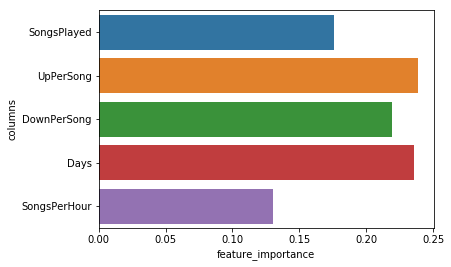

In [46]:
feature_importances = cvModel_gbt.bestModel.stages[2].featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': input_cols})
sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)

We can see that UpPerSong (thumbs up/no of songs) is the most important feature in predicting user churn. Other important features include Days (length of the sessions in days), and DownPerSong (thumbs down/no of songs) for a user.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.


Conclusion: 
To summarize our solution for the Sparkify Project, we execute the following steps:
Load the dataset into and clean it
Calculate features that help us model our solution
Feed the newly calculated features into 3 machine learning algorithms. Find the best hyperparameters and the model amongst them
Calculate the features that are most important in predicting user churn

One of the interesting yet difficult things during the project is brainstroming the features that we can derived from the data we have on hand. Developing useful features is crucial to developing a good model, and requires a lot of energy and efforts.  
Based on intuition I selected features which I thought would be useful in predicting churn.

The features can be improved a lot after considering more factors, adding more domain knowledges and expertise. Other features that I could have used are:no of friends added, no of songs added to playlist etc.

Also, currently I have used only a mini subset of the data set due to limitations of running the model on my laptop. If I use a bigger datset (using AWS or IBM Cloud), the model would be more accurate and robust.

In [48]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Sparkify.ipynb to html',
 '[NbConvertApp] Writing 396118 bytes to Sparkify.html',
 '[NbConvertApp] Converting notebook Sparkify-zh.ipynb to html',
 '[NbConvertApp] Writing 279513 bytes to Sparkify-zh.html']